In [3]:
import time
import numpy as np
import qiskit
from qiskit.opflow import X,Z,I
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import StatevectorSimulator, AerSimulator
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.sparse.linalg.eigen.arpack as arp
%matplotlib inline

Ising Hamiltonian with transverse and longitudinal field

In [4]:
# copypaste niccolo's code
def QNKron(N,op1,op2,pos): 
    '''
    Tensor product operator (Qiskit Pauli operators)
    returns tensor product of op1,op2 on sites pos,pos+1 and identity on remaining sites

    N:number of sites
    op1,op2: Pauli operators on neighboring sites
    pos: site to insert op1
    '''
    temp=np.array([I]*(N))
    temp[pos]=op1 
    if pos!=(N-1):
        temp[pos+1]=op2
    mat=1
    for j in range(N):
        mat=mat^temp[j]
    return mat

def NKron(N,op1,op2,pos): 
    '''
    Tensor product operator 
    returns tensor product of op1,op2 on sites pos,pos+1 and identity on remaining sites

    N:number of sites
    op1,op2: Pauli operators on neighboring sites
    pos: site to insert op1
    
    '''
    ide=np.eye(2)
    temp=np.array([ide]*(N),dtype=np.complex128)
    temp[pos,:,:]=op1 
    # if pos!=(N-1):
    temp[(pos+1)%N,:,:]=op2
    mat=1
    for j in range(N):
        mat=np.kron(mat,temp[j])
    return mat

def QHIsing(L,J,gx,gz):
    '''
    Quantum Ising Hamiltonian (1D) with transverse & longitudinal field (Qiskit Pauli operators)
    
    L:number of sites 
    J: hopping
    gx: transverse field
    gz: longitudinal field
    '''

    H=-J*QNKron(L,Z,Z,0)-gx*QNKron(L,X,I,0)-gz*QNKron(L,Z,I,0)
    for i in range(1,L-1):
        H=H-J*QNKron(L,Z,Z,i)-gx*QNKron(L,X,I,i)-gz*QNKron(L,Z,I,i)
    H=H-gx*QNKron(L,X,I,L-1)-gz*QNKron(L,Z,I,L-1)
    return H

def Mag(L,anti): #magnetization operator (numpy array)
    sz=np.array([[1,0],[0,-1]])
    M=np.zeros((2**L,2**L))
    for i in range(L):
        M=M+(anti**i)*NKron(L,sz,np.eye(2),i)
    return M/L

def QMag(L,anti): #magnetization operator (Qiskit operator)
    M=QNKron(L,Z,I,0)
    for i in range(1,L):
        M=M+(anti**i)*QNKron(L,Z,I,i)
    return M/L

def ising_groundstate(L, J, gx, gz):
    """For comparison: obtain ground state energy from exact diagonalization.

    Exponentially expensive in L, only works for small enough `L` <~ 20.
    
    L:number of sites 
    J: hopping
    gx: transverse field
    gz: longitudinal field
    '''
    """
    if L >= 20:
        warnings.warn("Large L: Exact diagonalization might take a long time!")
    # get single site operaors
    sx = sparse.csr_matrix(np.array([[0., 1.], [1., 0.]]))
    sz = sparse.csr_matrix(np.array([[1., 0.], [0., -1.]]))
    id = sparse.csr_matrix(np.eye(2))
    sx_list = []  # sx_list[i] = kron([id, id, ..., id, sx, id, .... id])
    sz_list = []
    for i_site in range(L):
        x_ops = [id] * L
        z_ops = [id] * L
        x_ops[i_site] = sx
        z_ops[i_site] = sz
        X = x_ops[0]
        Z = z_ops[0]
        for j in range(1, L):
            X = sparse.kron(X, x_ops[j], 'csr')
            Z = sparse.kron(Z, z_ops[j], 'csr')
        sx_list.append(X)
        sz_list.append(Z)
    H_zz = sparse.csr_matrix((2**L, 2**L))
    H_x = sparse.csr_matrix((2**L, 2**L))
    for i in range(L - 1):
        H_zz = H_zz + J*sz_list[i] * sz_list[(i + 1) % L]
    for i in range(L):
        H_x = H_x + gx*sx_list[i] +gz*sz_list[i]
    H = - H_zz - H_x
    E, V = arp.eigsh(H, k=1, which='SA', return_eigenvectors=True, ncv=20)
    return V[:,0], E[0], H

def sort_vals(vals):
    """ vals is (unsorted) dictionary of parameters from VQE ansatz circuit, this returns sorted values as list """
    indices = np.array([_.index for _ in vals])           # unordered list of indices from the ParameterVectorElement(Theta(INDEX))
    vals_sorted = np.array([vals[_] for _ in vals])       # unordered list of values (but same ordering as indices)
    return vals_sorted[np.argsort(indices)]

def init_vqe(vals, reps=3):
    return qiskit.circuit.library.EfficientSU2(L, reps=reps).assign_parameters(sort_vals(vals))

Obtain the VQE parameters using StatevectorSimulator (NOT NOISY)

gx: 0.01, gz: 0.01


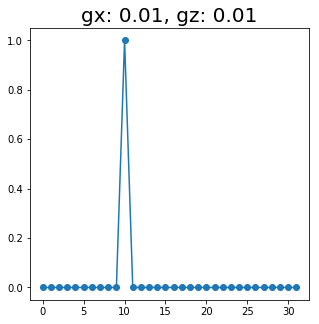

gx: 0.01, gz: 0.03


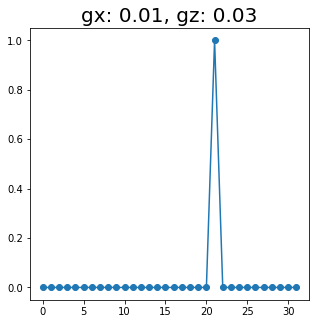

gx: 0.01, gz: 0.08


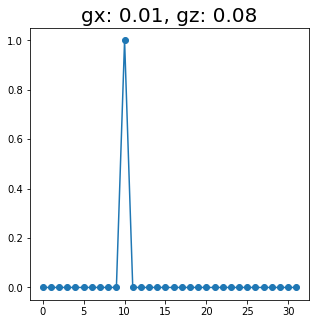

gx: 0.01, gz: 0.22


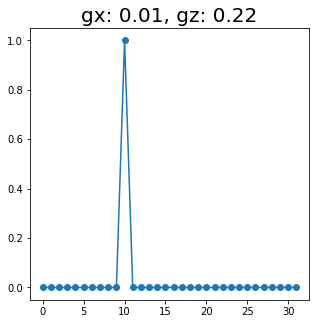

gx: 0.01, gz: 0.60


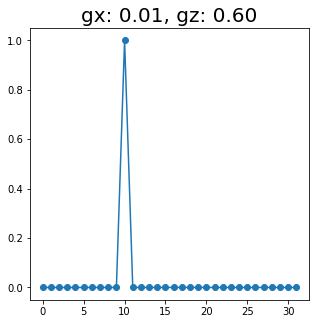

gx: 0.01, gz: 1.67


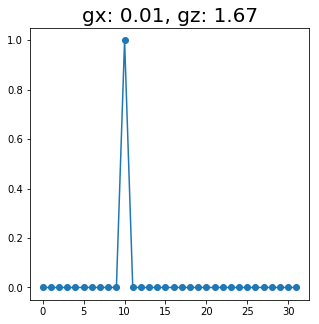

gx: 0.01, gz: 4.64


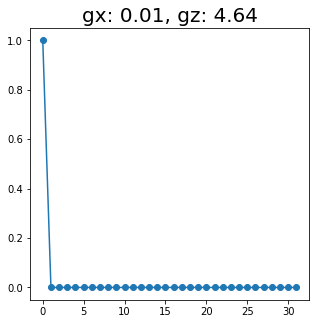

gx: 0.01, gz: 12.92


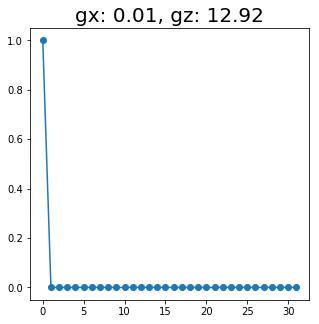

gx: 0.01, gz: 35.94


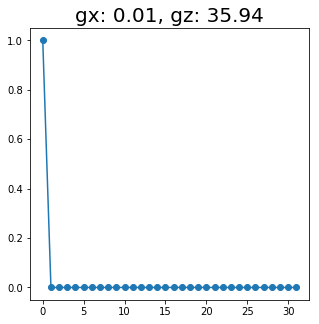

gx: 0.01, gz: 100.00


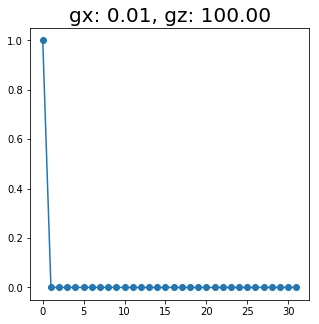

gx: 0.03, gz: 0.01


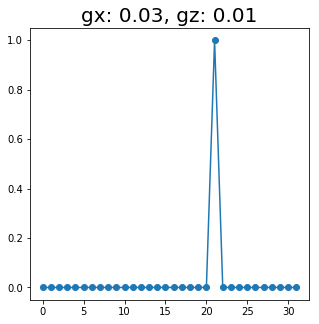

gx: 0.03, gz: 0.03


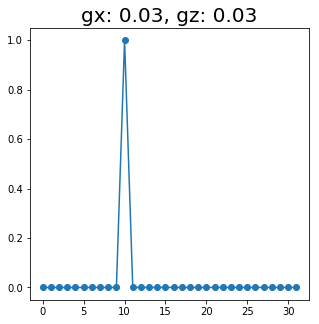

gx: 0.03, gz: 0.08


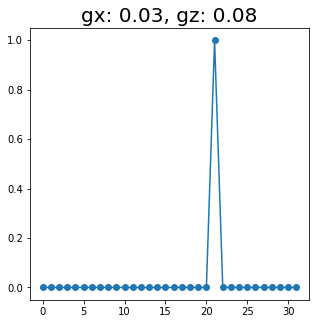

gx: 0.03, gz: 0.22


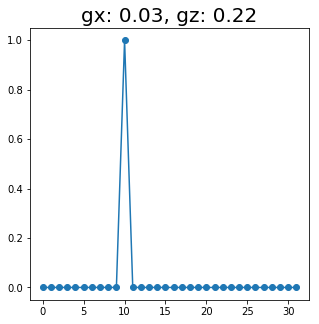

gx: 0.03, gz: 0.60


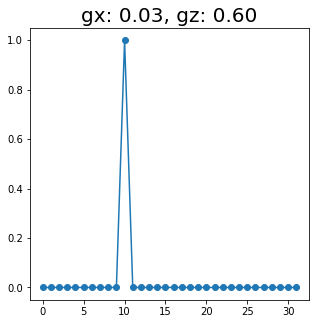

gx: 0.03, gz: 1.67


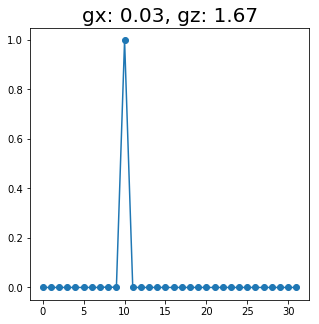

gx: 0.03, gz: 4.64


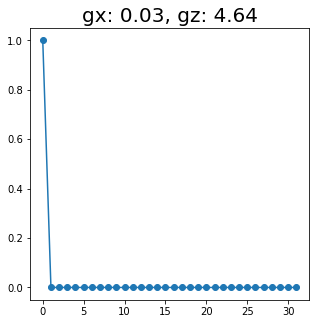

gx: 0.03, gz: 12.92


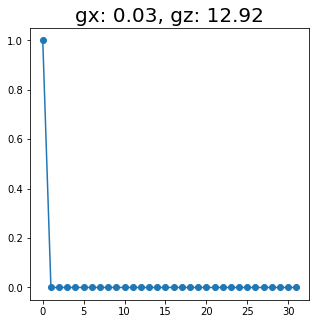

gx: 0.03, gz: 35.94


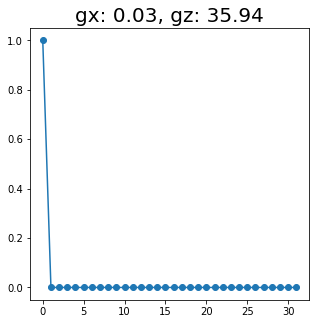

gx: 0.03, gz: 100.00


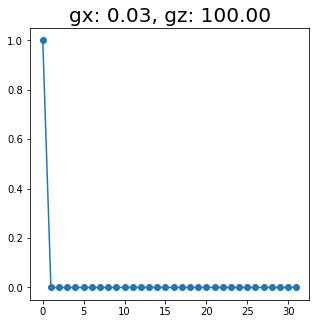

gx: 0.08, gz: 0.01


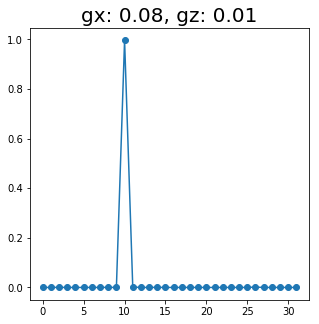

gx: 0.08, gz: 0.03


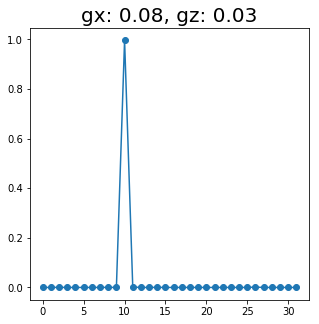

gx: 0.08, gz: 0.08


In [ ]:
L = 5
anti = -1.

gx_list = np.logspace(-2,2,10)
gz_list = np.logspace(-2,2,10)

backend = StatevectorSimulator()
optimizer = SLSQP(maxiter=1000)
ansatz = qiskit.circuit.library.EfficientSU2(L, reps=3)

#backend= AerSimulator() 
#optimizer = SPSA(maxiter=1000)
#ansatz = qiskit.circuit.library.EfficientSU2(L, reps=3)

vqe = VQE(ansatz, optimizer, quantum_instance=backend) 

opt_params = dict()

for i,gx in enumerate(gx_list):
    for j,gz in enumerate(gz_list):
    
        print('gx: %.2f, gz: %.2f' %(gx,gz))

        H = QHIsing(L,anti,np.float32(gx),np.float32(gz))
        result = vqe.compute_minimum_eigenvalue(H) #ED with Qiskit VQE
        opt_params[(gx,gz)] = result.optimal_parameters

        plt.figure(figsize=(5,5))
        plt.plot(abs(np.conjugate(result.eigenstate)*result.eigenstate), 'o-')
        plt.title('gx: %.2f, gz: %.2f' %(gx,gz), fontsize=20)
        plt.show()
    
np.save('params_VQE_Ising_L%.0f_anti_%.0f.npy' %(L,anti), opt_params)

In [ ]:
L = 5
anti = -1.

VQE_vals = np.load(f'params_VQE_Ising_L{L}_anti_%.0f.npy' %anti, allow_pickle=True).item()
fields = np.array([_ for _ in VQE_vals]) # list of lambda values (the items in the dictionary)
gx_list = np.unique(fields[:,0])
gz_list = np.unique(fields[:,1])

mag = QMag(L,anti) #magnetization operator (Qiskit)
Smag=Mag(L,anti) #magnetization operator (numpy)
# the ~ is the adjoint, but also it turns the is_measurement attribute to True
~StateFn(mag)
# state is technically a circuit, that prepares the ground state via VQE circuit
#state.draw() # uncomment to see, but is very long

Qen=np.zeros((len(gx_list),len(gz_list))); Sen=np.zeros((len(gx_list),len(gz_list))) #energies
Qmags=np.zeros((len(gx_list),len(gz_list))); Smags=np.zeros((len(gx_list),len(gz_list))) #magnetizations

In [ ]:
for i,gx in enumerate(gx_list):
    
    for j,gz in enumerate(gz_list):

        H = QHIsing(L, anti, np.float32(gx), np.float32(gz)) # build Hamiltonian Op
        state = init_vqe(VQE_vals[(gx,gz)])
        StateFn(state)   
        meas_outcome = ~StateFn(mag) @ StateFn(state)
        Qmags[i][j]=meas_outcome.eval()
        e_outcome = ~StateFn(H) @ StateFn(state)
        Qen[i][j]=e_outcome.eval()

        init_state, E, ham = ising_groundstate(L, anti, np.float(gx), np.float(gz))
        Sen[i][j]=E
        Smags[i][j]=init_state.T.conj()@Smag@init_state #Magnetization with Numpy results

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_list, gx_list, Smags.T, cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Magnetization ED - anti",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_list, gx_list, Smags.T, cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Magnetization VQE - anti",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_list, gx_list, Sen.T, cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Energies ED - anti",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_list, gx_list, Qen.T, cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Energies VQE - anti",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)